In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer

In [2]:
# Matrix of step functions

def stepfunctions(dim = 128, right_amplitudes = [0], left_amplitudes = [5]):

  """
  Inputs:
  -------
  - dim: int equal to the dimension of the step functions
  - left_amplitudes: array containing the values of the functions before the transition of size M. 
  - right_amplitudes: array containing the values of the functions after the transition of size M. 

  left_amplitudes and right_amplitudes should have the same size M. For each index i in range of M, dim step functions will be constructed having 
  the value before the transition equal to left_amplitudes[i] and the value after the transition equal to right_amplitudes[i]. 
  The step functions for the same index i, will vary in the position of the transition. 
  Taking all possible cases, we obtain, for each index i, dim step functions.

  Output:
  ------
  The output are two matrix of dimension (dim, M*dim + 1). The columns of this matrix are the step functions.
  """
  
  M = len(left_amplitudes)

  X = torch.zeros(((dim+1)*M, dim))
  
  for i in range(M):
    X[i*(dim + 1): (i+1)*(dim) + i, :] = right_amplitudes[i] * torch.tril(torch.ones(dim, dim)) + left_amplitudes[i] * torch.triu(torch.ones(dim, dim),diagonal=1)
    X[(i+1)*(dim) + i, :] = torch.ones(dim) * right_amplitudes[i]
                            
  return X

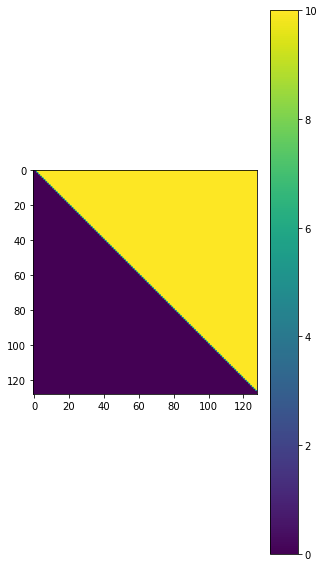

In [3]:
%matplotlib inline

# testing the method for step functions with different amplitudes
left_amp = [0,]
right_amp = [10]

X_test = stepfunctions(128, left_amp, right_amp)

r = torch.randperm(X_test.shape[0])
X = X_test[r,:]

plt.figure(figsize = (5,10))
plt.imshow(X_test)
plt.colorbar()

In [4]:
class AutoEncoder(nn.Module):

  def __init__(self, encoder, decoder):
    super(AutoEncoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    
    self.track_grads = False

  def forward(self, X):
    
    self.code = self.encoder(X)
    
    self.y = self.decoder(self.code)

    return self.y
            

  def track_gradients(self, track = False, params = 'all', names = []):
    """
    This function starts or stops the gradient tracking.
    In case we want to start the tracking, it takes the names of the weights to be tracked and prepares the containers.
    """
    self.track_grads = track

    if track:
        self.grads = []
        
        if params == 'all':
            for name, param in list(self.named_parameters()):
                self.grads.append({
                    'name': name,
                    'grad': torch.zeros(param.shape)
                })
            
        elif params == 'some' and len(names)>0:
            for name, param in list(self.named_parameters()):
                if name in names:
                    self.grads.append({
                    'name': name,
                    'grad': torch.zeros(param.shape)
                }) 
                
        else:
            print('params takes a string: \'all\' or \'some\'. If \'some\', names shouldn\'t be empty.')
        



  def SGD_step(self, alpha= 1e-3):
     
    """
    This function loops over the parameters of the autoencoder and update them using SGD
    """
        
    for name, param in list(self.named_parameters()):
    
        with torch.no_grad():
            
            param -= alpha * param.grad
            
            if self.track_grads:

                for i in range(len(self.grads)):
                    if self.grads[i]['name'] == name:
                        self.grads[i]['grad'] = param.grad.clone()
                        break
                
        param.grad.zero_()
        
  def RMSprop_step(self, alpha= 1e-3, gamma = 0.9):
     
    """
    This function loops over the parameters of the autoencoder and update them using SGD
    """
        
    for name, param in list(self.named_parameters()):
    
        #with torch.no_grad():
            
            #param -= alpha * param.grad
            
            if self.track_grads:

                for i in range(len(self.grads)):
                    if self.grads[i]['name'] == name:
                        self.grads[i]['grad'] = param.grad.clone()
                        break
                
        #param.grad.zero_()
        
  
  

In [5]:
# Manual Convolution with padding = 'same'

def convolve(filt, X):

  """
  - filter: tensor of dimension (1,l). Where l is the length of the filter.
  - X: tensor of dimension (m, n). The convolution is applied on the columns of X.

  - Output: tensor of dimension (m,n)
  """

  nb_channels, l = filt.shape

  conv = torch.zeros((nb_channels, *X.shape))

  X = F.pad(X, (0,0, 1,1), mode='constant', value=0.0)

  for c in range(nb_channels):

    for i in range(X.shape[1] - l):
      print(X[:, i:i+l].shape, filt[c].shape)
      conv[c, :,i] = X[:, i:i+l]@filt[c]

  return conv

In [6]:
x[:,i:i+2] @ filt

NameError: name 'x' is not defined

In [ ]:
conv = torch.zeros(X.shape)
for i in range(X.shape[0] - 2):

  conv[i,:] =  filt @ x[i:i+2, :]
  print(filt[0] @ x[i:i+2, :])

In [ ]:
%matplotlib inline
x = X_test[[63],:]
filt = torch.tensor([[1,-1]], dtype= torch.float)
fm_z = convolve(filt,x)
print(fm_z.shape)
plt.plot(x[0])
plt.plot(fm_z[0,0])

## Weight initialization

In [7]:
class Encoder(nn.Module):
# This is a one layer encoder 
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()
    
    self.W1 = Parameter(torch.randn(n_code, n_in, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

In [8]:
class Decoder(nn.Module):
# This is a two layers decoder 
   
  def __init__(self, n_code, n_h1, n_out):
    super(Decoder, self).__init__()
    
    self.W2 = Parameter(torch.rand(n_h1, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b2 = Parameter(torch.rand(1, n_h1, dtype= torch.float)*0.01, requires_grad = True)
    
    self.W3 = Parameter(torch.rand(n_out, n_h1, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, code):
    
    self.a2 = F.relu(F.linear(code, self.W2, self.b2))
    self.y = F.relu(F.linear(self.a2, self.W3) + 0.5)
    
    return self.y

In [9]:
encoder = Encoder(128,1)
decoder = Decoder(1, 128, 128)

ae = AutoEncoder(encoder, decoder)
ae.track_gradients(track= True, params='some', names =['encoder.W1','decoder.b2', 'decoder.W3'])

In [10]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [11]:
colors = []

for i in np.linspace(0x0000FF,0xFFFF00, 128, dtype=int):
    colors.append('#%06X' % i)

In [12]:
optimizer = optim.Adagrad(ae.parameters(), lr=1e-4)

In [13]:
non_diag = torch.where(~torch.eye(128, dtype=bool))

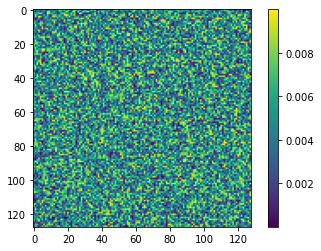

In [14]:
%matplotlib inline
plt.imshow(((ae.decoder.W3)).detach().numpy())
plt.colorbar()

In [15]:
ae.grads[1]['grad'].shape

torch.Size([1, 128])

<IPython.core.display.Javascript object>


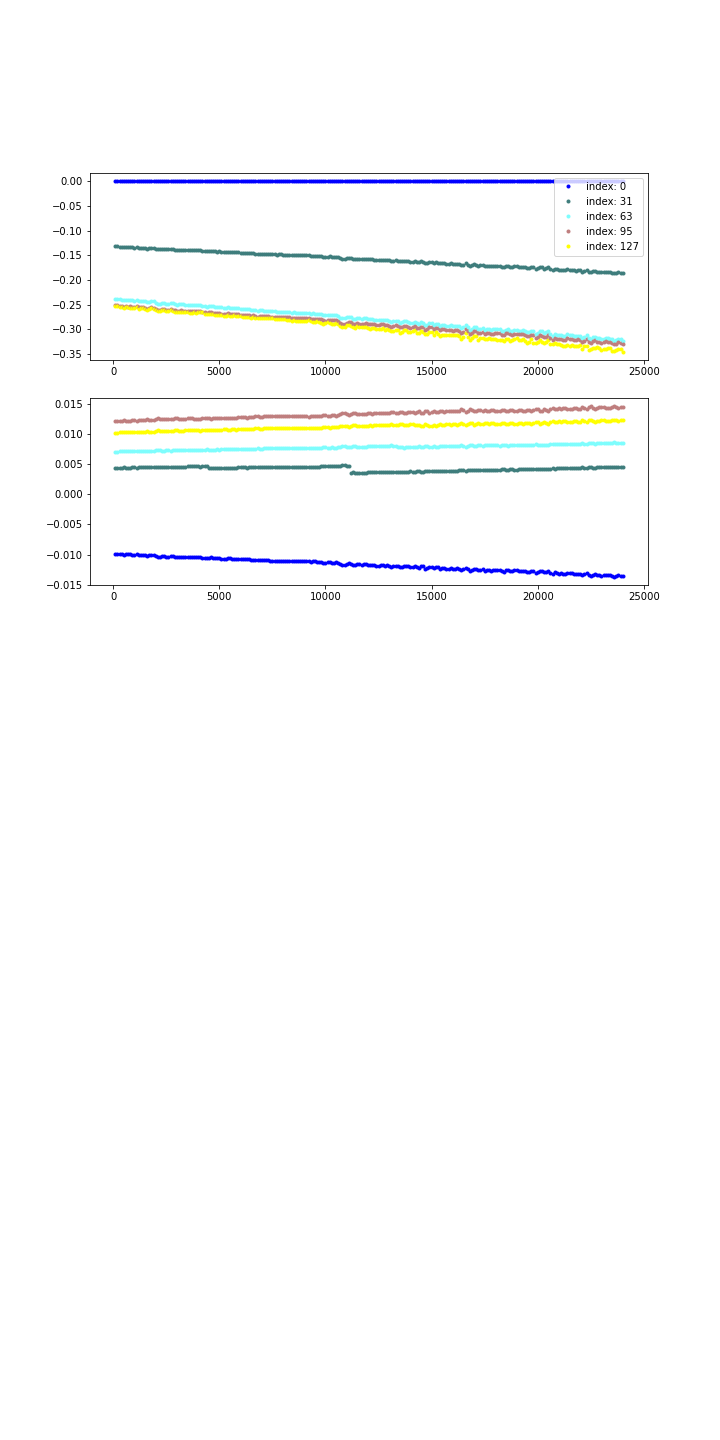

epoch 100 - loss: 3.8572093081474303
epoch 200 - loss: 3.8550932240486144
epoch 300 - loss: 3.8532121920585634
epoch 400 - loss: 3.8514019656181335
epoch 500 - loss: 3.8496236038208007
epoch 600 - loss: 3.8476049089431763
epoch 700 - loss: 3.845462110042572
epoch 800 - loss: 3.843482644557953
epoch 900 - loss: 3.841526403427124
epoch 1000 - loss: 3.8396539068222046
epoch 1100 - loss: 3.837508029937744
epoch 1200 - loss: 3.8355686616897584
epoch 1300 - loss: 3.833808569908142
epoch 1400 - loss: 3.8318417119979857
epoch 1500 - loss: 3.829767868518829
epoch 1600 - loss: 3.828137903213501
epoch 1700 - loss: 3.8262527322769166
epoch 1800 - loss: 3.8238913726806643
epoch 1900 - loss: 3.8217986679077147
epoch 2000 - loss: 3.820249283313751
epoch 2100 - loss: 3.8187934255599973
epoch 2200 - loss: 3.816887516975403
epoch 2300 - loss: 3.814687671661377
epoch 2400 - loss: 3.81255065202713
epoch 2500 - loss: 3.810741136074066
epoch 2600 - loss: 3.8089413976669313
epoch 2700 - loss: 3.8068381071090

epoch 21700 - loss: 3.479110586643219
epoch 21800 - loss: 3.4778342628479004
epoch 21900 - loss: 3.476155219078064
epoch 22000 - loss: 3.474324793815613
epoch 22100 - loss: 3.4732857847213747
epoch 22200 - loss: 3.4721003413200378
epoch 22300 - loss: 3.4696342754364013
epoch 22400 - loss: 3.468447961807251
epoch 22500 - loss: 3.467836980819702
epoch 22600 - loss: 3.465948941707611
epoch 22700 - loss: 3.463716835975647
epoch 22800 - loss: 3.462411515712738
epoch 22900 - loss: 3.461058237552643
epoch 23000 - loss: 3.459868321418762
epoch 23100 - loss: 3.4583834195137024
epoch 23200 - loss: 3.456458714008331
epoch 23300 - loss: 3.454887640476227
epoch 23400 - loss: 3.453487124443054
epoch 23500 - loss: 3.4521070432662966
epoch 23600 - loss: 3.4509596681594847
epoch 23700 - loss: 3.4495717811584474
epoch 23800 - loss: 3.4475748419761656
epoch 23900 - loss: 3.44586051940918
epoch 24000 - loss: 3.444724454879761


KeyboardInterrupt: 

In [19]:
%matplotlib notebook
#
nb_epochs = 50000
t=100

losses = []
avg_loss = np.zeros(t)

# Visualization 
#nb_grads = len(ae.grads)
fig, axes = plt.subplots(5,1,figsize = (10,20))

fig.show()
fig.canvas.draw()

legends = True

alpha = 5e-4

for epoch in range(nb_epochs):

  Y = ae.forward(X)
  loss = torch.mean(torch.mean((Y-X)**2,0)) #+ 0.1*torch.mean((ae.decoder.W3@ae.decoder.W3.T)[non_diag[0],non_diag[1]])
    
  avg_loss[epoch%t] = loss

  #optimizer.zero_grad()

  loss.backward()

  #optimizer.step()
  ae.SGD_step(alpha = alpha)



  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    
    axes[2].clear()
    axes[3].clear()
    axes[4].clear()
    
    # Visualization
    for i in np.linspace(0,127,5, dtype=int):
        axes[0].plot(epoch+1, ae.grads[0]['grad'][0,i].detach().numpy(),'.', color = colors[i], label=f'index: {i}')
        axes[1].plot(epoch+1, ae.grads[1]['grad'][0,i].detach().numpy(),'.', color = colors[i], label=f'index: {i}')
        
        axes[2].plot(ae.grads[2]['grad'][i,:].detach().numpy(), label=f'index: {i}')
    #axes[2].imshow((ae.decoder.W3>0).detach().numpy())
    
    z_test = ae.encoder(X_test)
    axes[3].plot(np.arange(X_test.shape[0]),z_test[:,0].detach().numpy())
    #axes[3].plot(np.arange(X_test.shape[0]),z_test[:,1].detach().numpy())
    
    for n in np.arange(0, X_test.shape[0], 8):
        axes[4].plot(ae.forward(X_test[[n],:]).detach().numpy().ravel())
    
    axes[2].legend()
    
    if legends:
        axes[0].legend()
        axes[1].legend()
        
        legends = False
        
    fig.canvas.draw()

Text(0.5, 1.0, 'Predicted')

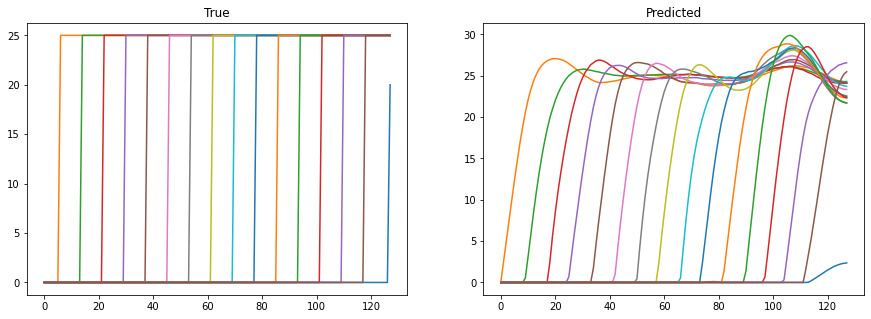

In [118]:
%matplotlib inline
fig = plt.figure(figsize = (15,5))

axes = fig.subplots(1,2)

for n in np.arange(128*3, 128*4, 8):
  axes[0].plot(X_test[n,:], label = n)
  axes[1].plot(ae.forward(X_test[[n],:]).detach().numpy().ravel(), label = n)

axes[0].set_title("True")
#axes[0].legend()
axes[1].set_title("Predicted")
#axes[1].legend()

In [ ]:
ae.grads